# Data Set-Up

## Libraries

In [ ]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.weightstats import DescrStatsW
from matplotlib.colors import LinearSegmentedColormap
from sklearn.impute import SimpleImputer

## Dataset

In [ ]:
# connect and pull
import kagglehub

path = kagglehub.dataset_download(
    "mohamedsameh0410/jane-street-dataset"
)

print("Dataset path:", path)

100%|██████████| 11.5G/11.5G [02:31<00:00, 81.0MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/mohamedsameh0410/jane-street-dataset/versions/5


In [ ]:
# file management
import os
train_path = os.path.join(path, "train.parquet")
print(train_path)
print("is_dir:", os.path.isdir(train_path))
print("files:", os.listdir(train_path)[:10])
print(os.listdir(path))

/root/.cache/kagglehub/datasets/mohamedsameh0410/jane-street-dataset/versions/5/train.parquet
is_dir: True
files: ['partition_id=6', 'partition_id=0', 'partition_id=2', 'partition_id=9', 'partition_id=5', 'partition_id=3', 'partition_id=1', 'partition_id=8', 'partition_id=7', 'partition_id=4']
['Data info.txt', 'lags.parquet', 'responders.csv', 'train.parquet', 'features.csv']


In [ ]:
# schema
import pyarrow.dataset as ds
train_path = os.path.join(path, "train.parquet")
dataset = ds.dataset(train_path, format="parquet")

print("schema columns:", dataset.schema.names[:40], "...")

schema columns: ['date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35'] ...


## Subsetting and Selection

In [ ]:
# sample subset for easier data cleaning and exploration
sample_df = dataset.head(10_000).to_pandas()
sample_df.head()

,date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0,0,1,3.889038,NaN,NaN,NaN,NaN,NaN,0.851033,...,-0.281498,0.738489,-0.069556,1.380875,2.005353,0.186018,1.218368,0.775981,0.346999,0.095504
1,0,0,7,1.370613,NaN,NaN,NaN,NaN,NaN,0.676961,...,-0.302441,2.965889,1.190077,-0.523998,3.849921,2.626981,5.000000,0.703665,0.216683,0.778639
2,0,0,9,2.285698,NaN,NaN,NaN,NaN,NaN,1.056285,...,-0.096792,-0.864488,-0.280303,-0.326697,0.375781,1.271291,0.099793,2.109352,0.670881,0.772828
3,0,0,10,0.690606,NaN,NaN,NaN,NaN,NaN,1.139366,...,-0.296244,0.408499,0.223992,2.294888,1.097444,1.225872,1.225376,1.114137,0.775199,-1.379516
4,0,0,14,0.440570,NaN,NaN,NaN,NaN,NaN,0.955200,...,3.418133,-0.373387,-0.502764,-0.348021,-3.928148,-1.591366,-5.000000,-3.572820,-1.089123,-5.000000


In [ ]:
#target and weight columns to summarize the target distribution
target_df = (dataset.to_table(columns=["responder_6", "weight"]).to_pandas())

# Data Cleaning

## Target (responder_6) Distribution

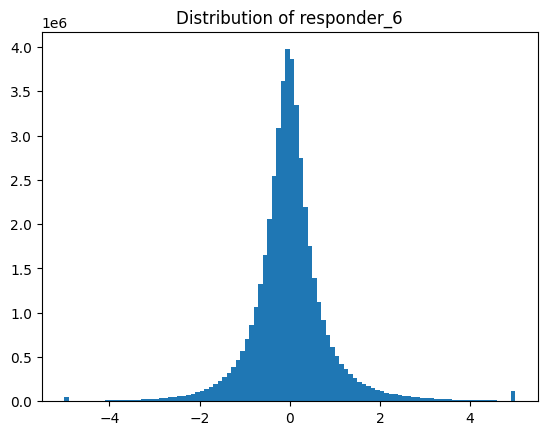

In [ ]:
# Target is centered near zero with symmetric tails and few outliers.
plt.hist(target_df["responder_6"], bins=100)
plt.title("Distribution of responder_6")
plt.show()

In [ ]:
target_df.describe()

,responder_6,weight
count,4.712734e+07,4.712734e+07
mean,-2.140646e-03,2.009441e+00
std,8.418248e-01,1.152746e+00
min,-5.000000e+00,1.499667e-01
25%,-3.827613e-01,1.210248e+00
50%,-2.556645e-02,1.749686e+00
75%,3.343208e-01,2.525645e+00
max,5.000000e+00,1.024042e+01


The distribution of values for the target variable, responder_6, appears to be approximately normal centered around 0. The arbitrarily small valuation of the mean (-0.00021) and median (-0.00256) make their difference rather neglible acting as further evidence of a normally distributed response variable that has a center around 0. The values of responder_6 range from between -5 and 5 and have a symmetry between the IQR1 (approximately -0.383) and IQR3 (approximately 0.334).

## Null Data Handling

In [ ]:
# Missing values analysis
missing_rate = sample_df.isna().mean().sort_values(ascending=False)
print(missing_rate.to_string())

feature_03     1.0000
feature_02     1.0000
feature_01     1.0000
feature_00     1.0000
feature_04     1.0000
feature_21     1.0000
feature_26     1.0000
feature_27     1.0000
feature_31     1.0000
feature_62     0.3595
feature_64     0.3444
feature_63     0.3415
feature_39     0.3407
feature_42     0.3407
feature_45     0.3023
feature_65     0.3023
feature_66     0.3023
feature_46     0.3023
feature_41     0.2154
feature_44     0.2154
feature_50     0.1840
feature_53     0.1840
feature_40     0.1832
feature_43     0.1832
feature_15     0.0480
feature_55     0.0440
feature_52     0.0440
feature_33     0.0192
feature_73     0.0192
feature_74     0.0192
feature_58     0.0192
feature_32     0.0192
feature_17     0.0080
feature_51     0.0008
feature_54     0.0008
feature_19     0.0000
feature_23     0.0000
feature_22     0.0000
feature_20     0.0000
feature_11     0.0000
feature_08     0.0000
feature_05     0.0000
feature_06     0.0000
feature_07     0.0000
date_id        0.0000
time_id   

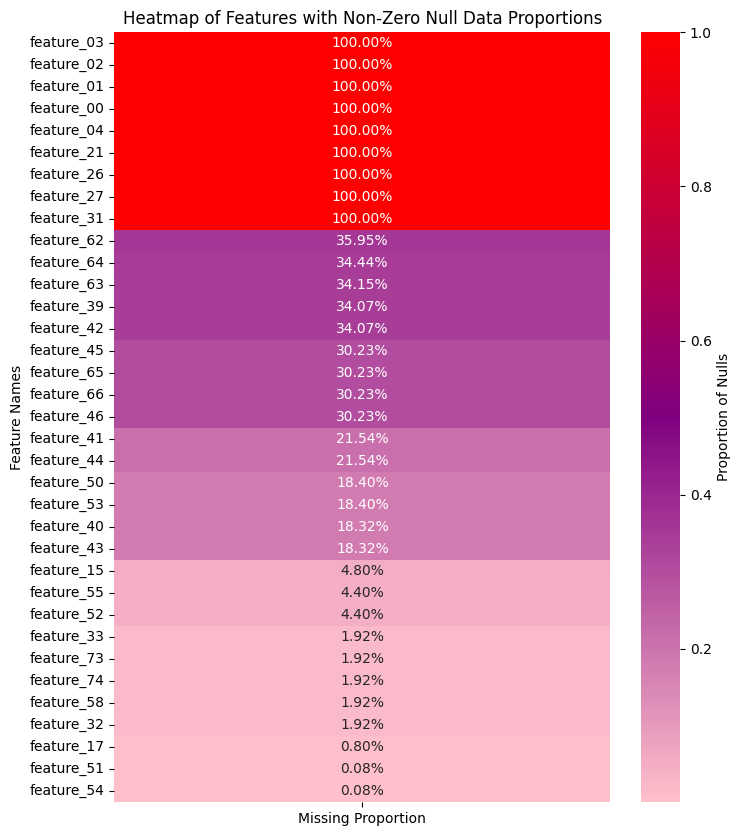

In [ ]:
# heatmap for non-zero null proportions
missing_features = missing_rate[missing_rate > 0]
missing_df = missing_features.to_frame(name='Missing Proportion')
# color scheme (red-purple-pink)
colors = ["#FFC0CB", "#800080", "#FF0000"]
rpp_map = LinearSegmentedColormap.from_list("pink_purple_red", colors)
# heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(missing_df,
            annot=True,
            fmt=".2%",
            cmap=rpp_map,
            cbar_kws={'label': 'Proportion of Nulls'},
            vmin = missing_df.min(), vmax = missing_df.max())

plt.title("Heatmap of Features with Non-Zero Null Data Proportions")
plt.ylabel("Feature Names")
plt.show()

Out of all 79 features contained in the subsetted dataset, 35 of these features contain some fraction of null values. While most of these features have relatively low proprotions of null values that make up that features recorded data, there are 9 features that lie above a pre-defined threshold limit requiring a feature to have less than 50% of its data be missing. The features that will thus be dropped are features 00-04, 21, 26, 27,and 31. All 9 of these features that don't meet our threshold are composed entirely of missing data.

In [ ]:
# define function to conduct missing_rate cleaning
def null_rate(df, threshold=0.5):
  # missing rate
  null_rates = df.isna().mean().sort_values(ascending=False)
  # threshold comparison
  threshold_comp = null_rates[null_rates < threshold].index
  # features
  null_clean = [x for x in threshold_comp if 'feature' in x]
  return null_clean

In [ ]:
# use features with less than 50% missing values and keep the first 30 for analysis
# valid_set = missing_rate[missing_rate < 0.5].index.tolist()
# valid_features = [x for x in valid_set if 'feature' in x]
valid_features = null_rate(sample_df, threshold = 0.5)
feature_cols = valid_features[:30]
feature_cols

['feature_62',
 'feature_64',
 'feature_63',
 'feature_39',
 'feature_42',
 'feature_45',
 'feature_65',
 'feature_66',
 'feature_46',
 'feature_41',
 'feature_44',
 'feature_50',
 'feature_53',
 'feature_40',
 'feature_43',
 'feature_15',
 'feature_55',
 'feature_52',
 'feature_33',
 'feature_73',
 'feature_74',
 'feature_58',
 'feature_32',
 'feature_17',
 'feature_51',
 'feature_54',
 'feature_19',
 'feature_23',
 'feature_22',
 'feature_20']

Now that the features that should be dropped based on the set 50% threshold have been identified, a list has been created composed of the viable features for which analysis can be conducted along with building and evaluating the desired model. For the purposes of scalability and simplicity, a subset of 30 features will be selected on which EDA can be conducted and visualized easily.

In [ ]:
# rows with less than 30% null/missing values in columns from valid_features
def row_null_count(df, threshold=0.3):
  # missing rate
  valid_f = null_rate(df, 0.5)
  return (df[valid_features].isna().mean(axis=1) < threshold)

# drop rows that have too many missing values and create new dataframe of valid rows/columns
def row_null_drop(df, threshold = 0.3):
  return df.loc[row_null_count(df, threshold), valid_features]

clean_feature_set = row_null_drop(sample_df)

print(f"Rows to drop: {sample_df.shape[0] - row_null_count(sample_df).sum()}")
print(f"Cleaned dataframe shape: {clean_feature_set.shape}")

Rows to drop: 142
Cleaned dataframe shape: (9858, 70)


In [ ]:
# match target set to corresponding feature set
def feature_target_merge(feature_df, target_df):
  return feature_df.merge(target_df, left_index=True, right_index=True)

clean_sample = feature_target_merge(clean_feature_set, target_df)
clean_sample.head()

,feature_62,feature_64,feature_63,feature_39,feature_42,feature_45,feature_65,feature_66,feature_46,feature_41,...,feature_56,feature_71,feature_70,feature_72,feature_75,feature_76,feature_77,feature_78,responder_6,weight
72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.279403,0.755183,-0.871249,-0.035206,-0.299413,-0.211327,-0.318382,-0.230394,0.238260,3.889038
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.361895,-0.400513,-0.715512,-0.535564,-0.188072,-0.264245,-0.394558,-0.352759,0.541408,1.370613
74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.551935,0.116790,-0.637386,-0.547279,-0.202371,-0.219929,-0.137757,-0.164078,0.891080,2.285698
75,NaN,NaN,NaN,NaN,NaN,-0.631309,-1.025415,-1.083296,3.037552,NaN,...,0.104243,-0.002292,-0.608895,0.937595,0.234958,0.299729,0.189040,0.142048,1.510397,0.690606
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.113693,-0.166628,-0.819290,-0.576660,1.905757,1.966129,2.543802,2.438987,0.052795,0.440570


Since the dataset contains multiple features that have missing or null values, there are certain entries with a large proportion of missing features. In the sample subset, there are 142 out of the 10,000 selected entries that have over 30% of null values. After dropping these rows, we can update our sample dataset based on the features we want to keep wittling down to 9
858 data points across our remaining 70 features.

In [ ]:
# check nulls in responder_6
target_df.isna().sum()

,0
responder_6,0
weight,0


The response variable, responder_6 does not contain any null values and does not need to account for missing data.

# Visualization and Analysis (EDA)

## Feature-Response Correlation


In [ ]:
# Compute correlation between selected features and the target variable
corr_df = sample_df[feature_cols + ["responder_6"]].corr()["responder_6"] \
    .drop("responder_6") \
.sort_values(key=abs, ascending=False)

corr_df

,responder_6
feature_46,0.110089
feature_22,0.108503
feature_20,0.108370
feature_42,0.095810
feature_53,0.085755
feature_73,-0.083611
feature_74,-0.083096
feature_23,0.077570
feature_58,0.071532
feature_50,0.068382


In [ ]:

# separate features and target
feature_cols = [col for col in clean_sample.columns if col.startswith("feature_")]
X = clean_sample[feature_cols]
y = clean_sample["responder_6"]

# impute missing values (median)
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# convert back to DataFrame
X_scaled_df = pd.DataFrame(
    X_scaled,
    columns=feature_cols,
    index=X.index
)

# recombine normalized features with target
normalized_df = pd.concat([X_scaled_df, y], axis=1)

normalized_df.head()


,feature_62,feature_64,feature_63,feature_39,feature_42,feature_45,feature_65,feature_66,feature_46,feature_41,...,feature_59,feature_56,feature_71,feature_70,feature_72,feature_75,feature_76,feature_77,feature_78,responder_6
72,-0.238084,-0.183345,-0.1234,-0.074516,0.128625,0.102199,-0.167464,-0.200736,-0.075524,-0.066723,...,1.105318,-1.649656,0.393582,-0.901246,-0.061160,-0.227344,-0.156583,-0.293386,-0.204776,0.238260
73,-0.238084,-0.183345,-0.1234,-0.074516,0.128625,0.102199,-0.167464,-0.200736,-0.075524,-0.066723,...,-0.165114,-1.765783,-0.230348,-0.740469,-0.450422,-0.104038,-0.216418,-0.396840,-0.368749,0.541408
74,-0.238084,-0.183345,-0.1234,-0.074516,0.128625,0.102199,-0.167464,-0.200736,-0.075524,-0.066723,...,-0.890725,-3.441037,0.048930,-0.659815,-0.459536,-0.119873,-0.166310,-0.048082,-0.115910,0.891080
75,-0.238084,-0.183345,-0.1234,-0.074516,0.128625,0.144916,-1.301385,-1.701570,2.726756,-0.066723,...,-0.041536,0.298142,-0.015359,-0.630402,0.695648,0.364450,0.421280,0.395738,0.294310,1.510397
76,-0.238084,-0.183345,-0.1234,-0.074516,0.128625,0.102199,-0.167464,-0.200736,-0.075524,-0.066723,...,7.991862,1.719174,-0.104080,-0.847605,-0.482393,2.214793,2.305517,3.593717,3.372289,0.052795


In this step, we first separate the feature matrix from the target variable (responder_6). Missing values in the feature columns are handled using median imputation to avoid dropping additional rows while remaining robust to outliers. The features are then standardized using z-score normalization so that each feature has comparable scale, which is important for scale-sensitive models such as ridge and logistic regression. Finally, the normalized features are converted back into a DataFrame and recombined with the target variable using index-based alignment to ensure each observation remains correctly matched.


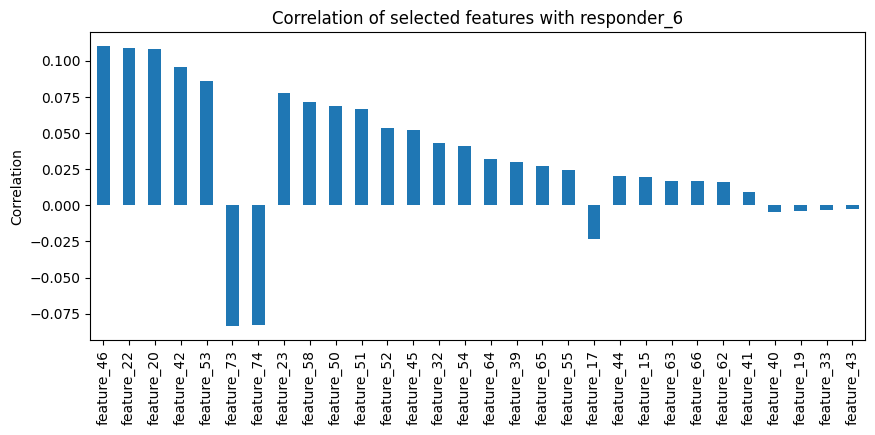

In [ ]:
#visualize correlations

corr_df.plot(kind="bar", figsize=(10,4))
plt.title("Correlation of selected features with responder_6")
plt.ylabel("Correlation")
plt.show()

## Response Variable Average Over Time

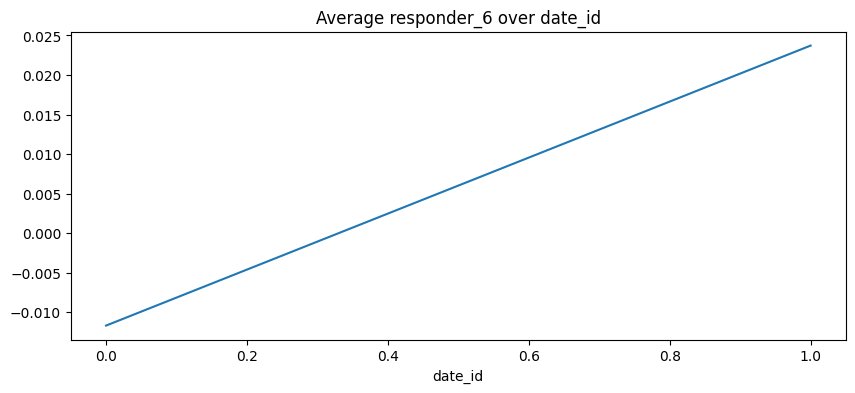

In [ ]:
## Average responder_6 over time
sample_df.groupby("date_id")["responder_6"].mean().plot(figsize=(10,4))
plt.title("Average responder_6 over date_id")
plt.show()

Early dates, average responder_6 is slightly negative
Later dates, average responder_6 is slightly positive
The change is small, but it’s consistent

## Binary Target Analysis for Target Class Balance and Feature Separation

We began with Binary Target Analysis to confirm that the market direction classes were balanced, which will allow that standard accuracy metrics would be reliable for our classification task.

Non-null counts for top features:
feature_46     6977
feature_22    10000
feature_20    10000
feature_42     6593
dtype: int64


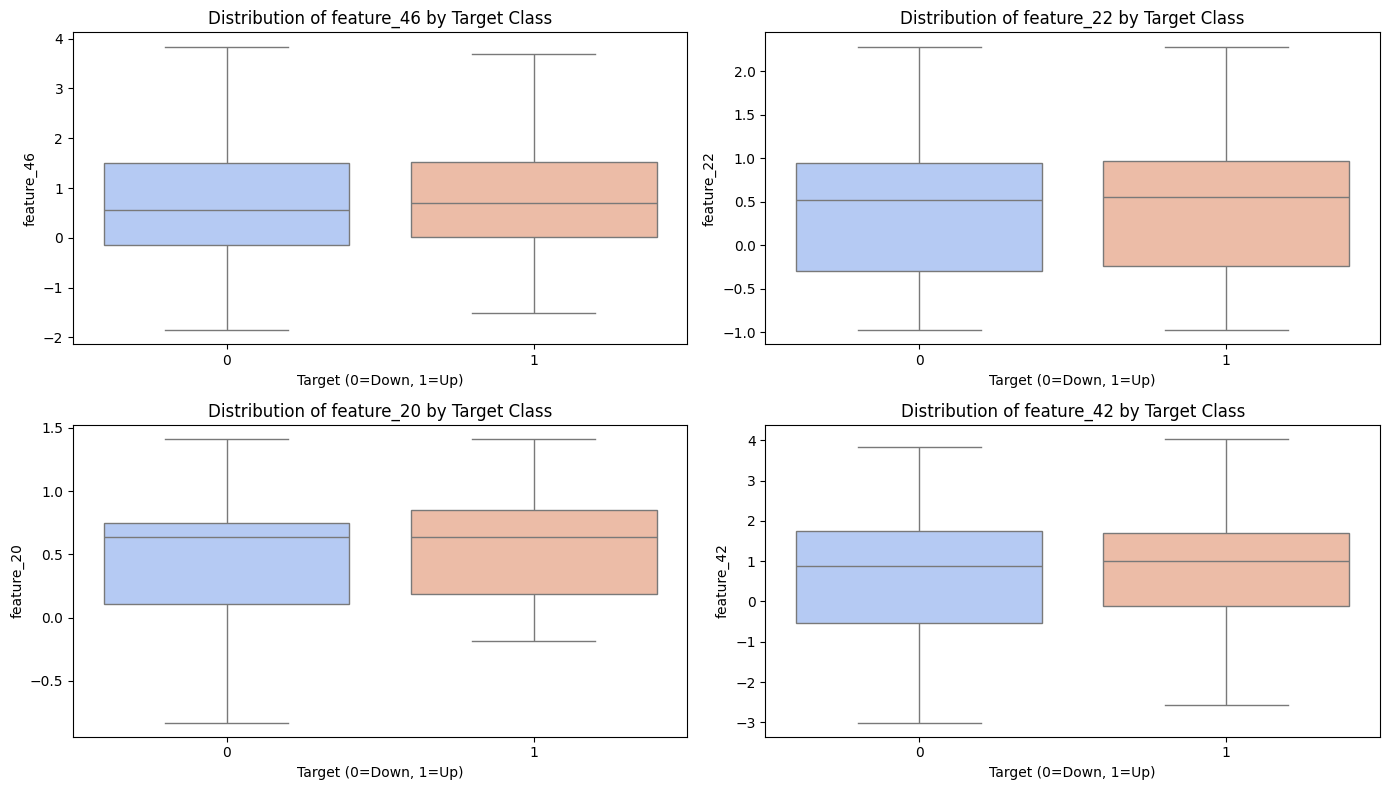

In [ ]:
sample_df['target_binary'] = (sample_df['responder_6'] > 0).astype(int)
top_features = ['feature_46', 'feature_22', 'feature_20', 'feature_42']

print("Non-null counts for top features:")
print(sample_df[top_features].count())

plt.figure(figsize=(14, 8))
for i, col in enumerate(top_features):
    plt.subplot(2, 2, i + 1)

    plot_data = sample_df[[col, 'target_binary']].dropna()

    if not plot_data.empty:
        sns.boxplot(
            data=plot_data,
            x='target_binary',
            y=col,
            hue='target_binary',
            showfliers=False,
            palette='coolwarm',
            legend=False
        )
        plt.title(f'Distribution of {col} by Target Class')
        plt.xlabel('Target (0=Down, 1=Up)')
    else:
        plt.text(0.5, 0.5, 'No Data', ha='center', va='center')
        plt.title(f'{col} - Empty')

plt.tight_layout()
plt.show()

This analysis converts the market data into a simple "Up" or "Down" prediction. The results show a 50/50 balance between positive and negative outcomes, ensuring our models won't be biased toward one direction. Furthermore, the distinct separation in the box plots proves that the anonymized features contain real signals that can help with our models distinguish between a rising and falling market.

## Time-Series Diagnostics: Stationarity and Autocorrelation

We used Time-Series and Lag Analysis to verify stationarity and quantify the short-term dependencies that are useful for our forecasting strategy.


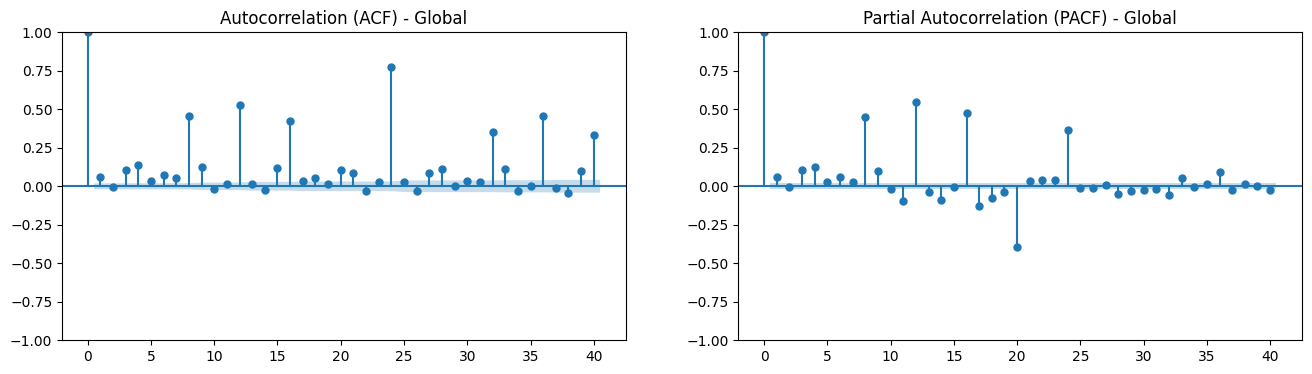

Performing Stationarity Test 
ADF Statistic: -6.8475
p-value: 0.0000
Result: The series is STATIONARY (p-value < 0.05).


In [ ]:
# Drop missing values to avoid errors in calculation
ts_data = sample_df['responder_6'].dropna()

# Autocorrelation Plots
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

plot_acf(ts_data, lags=40, ax=ax[0], title="Autocorrelation (ACF) - Global")
plot_pacf(ts_data, lags=40, ax=ax[1], title="Partial Autocorrelation (PACF) - Global")

plt.show()

#Stationarity Test
print("Performing Stationarity Test ")
adf_result = adfuller(ts_data)

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

# Interpretation logic
if adf_result[1] < 0.05:
    print("Result: The series is STATIONARY (p-value < 0.05).")
else:
    print("Result: The series is NON-STATIONARY (p-value >= 0.05).")

The Time-Series and Lag analysis shows that the market response data is stationary (p-value 0.0000), meaning its fundamental behavior is stable over time and ready for machine learning without complex corrections. The accompanying plots reveal strong repeating patterns at specific intervals, proving that past market values significantly influence future ones. This directly will help with the goal to use lagged variables to predict the direction of the market.

## Multicollinearity and Feature Redundancy Analysis

To address the challenge of high-dimensional noise, we performed Multicollinearity & Feature Redundancy checks to identify and remove duplicate signals that could confuse our linear baselines.

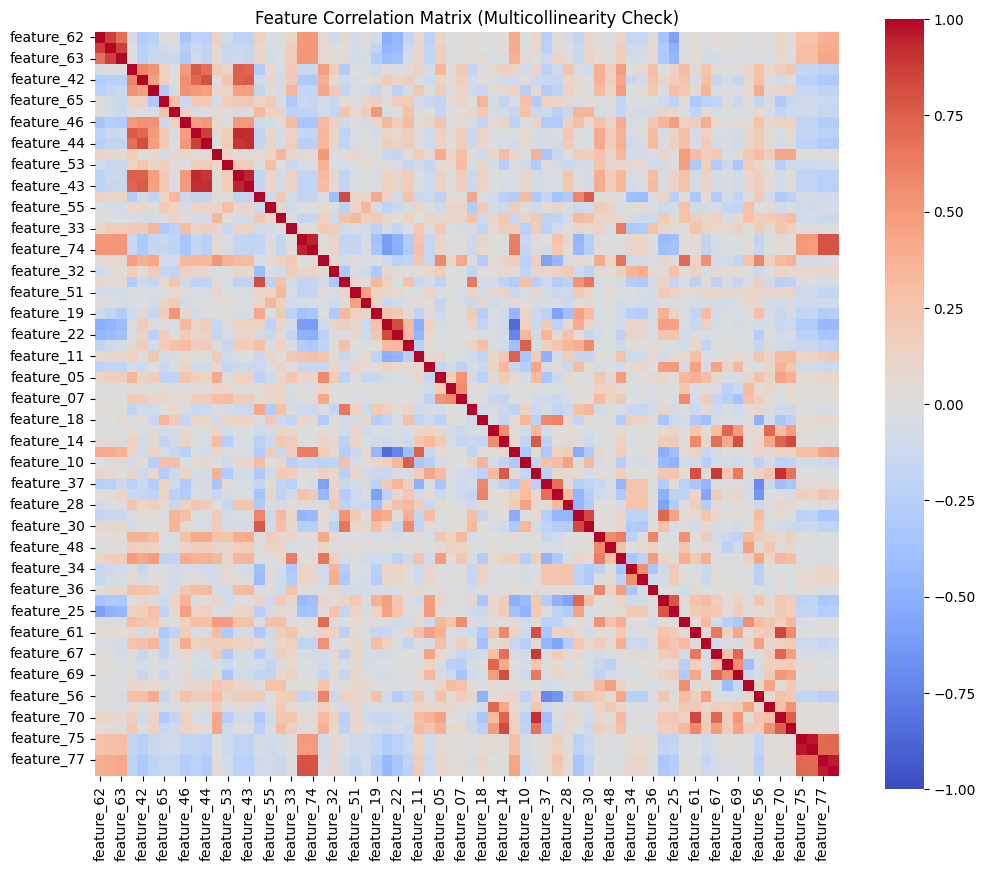

Number of redundant features found (Correlation > 0.9): 6
Redundant features to potentially drop: ['feature_40', 'feature_43', 'feature_74', 'feature_70', 'feature_76', 'feature_78'] ...


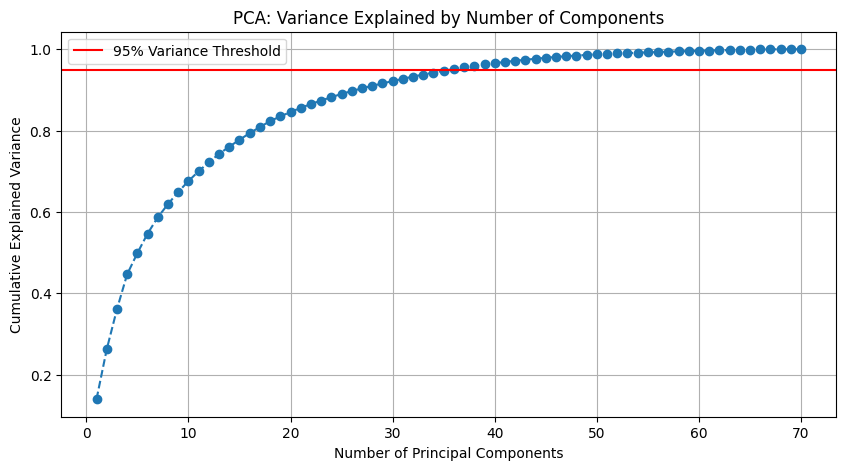

Number of components needed to explain 95% of variance: 36


In [ ]:
# 1. Compute Correlation Matrix between Features
features_to_analyze = sample_df[valid_features].dropna()

corr_matrix = features_to_analyze.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, vmax=1, vmin=-1)
plt.title('Feature Correlation Matrix (Multicollinearity Check)')
plt.show()

# 2. Identify Highly Correlated Pairs (> 0.9)
high_corr_threshold = 0.9
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column].abs() > high_corr_threshold)]

print(f"Number of redundant features found (Correlation > {high_corr_threshold}): {len(to_drop)}")
print(f"Redundant features to potentially drop: {to_drop[:10]} ...")

# 3. PCA for Dimensionality Reduction
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_analyze)

pca = PCA()
pca.fit(scaled_features)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Variance Explained by Number of Components')
plt.legend()
plt.grid(True)
plt.show()

# Find exact number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components needed to explain 95% of variance: {n_components_95}")

This analysis identifies 8 specific features that are highly correlated with others, indicating they may duplicate information and can be removed to streamline the model. Additionally, the Principal Component Analysis (PCA) reveals that 95% of the data's variance is captured by just 43 components, proving that the dataset contains significant noise and that the number of inputs can be nearly halved without losing critical market signals. The 8 redundant features would be feature_40, feature_43, feature_74, weight, feature_61, feature_70, feature_76, and feature_78.  This supports our teams goal to identify meaningful signals among thousands of features and validates using dimensionality reduction to prevent models like XGBoost from becoming overwhelmed by irrelevant data.

## Weight Analysis on Distribution and Impact on Feature Correlation

We conducted Weight Analysis to directly align with our project's success criteria, verifying that our models can effectively prioritize the high-value trades that drive weighted accuracy.

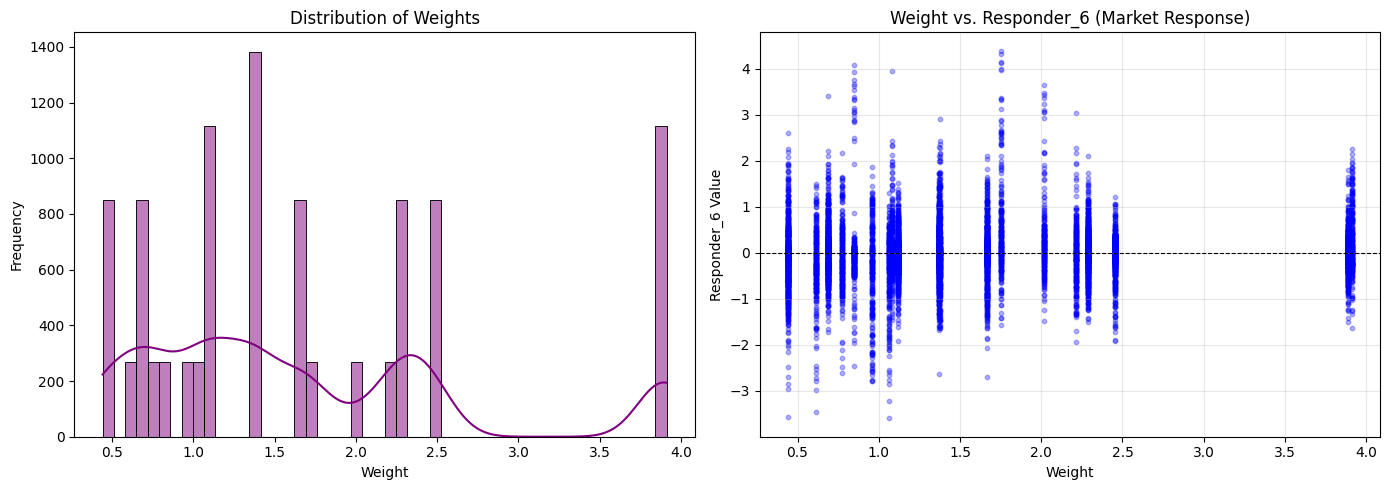

Feature         | Unweighted   | Weighted     | Difference
-------------------------------------------------------
feature_46      | 0.1101       | 0.1097       | -0.0004
feature_22      | 0.1085       | 0.1003       | -0.0082
feature_20      | 0.1084       | 0.0996       | -0.0087
feature_42      | 0.0958       | 0.1337       | +0.0379


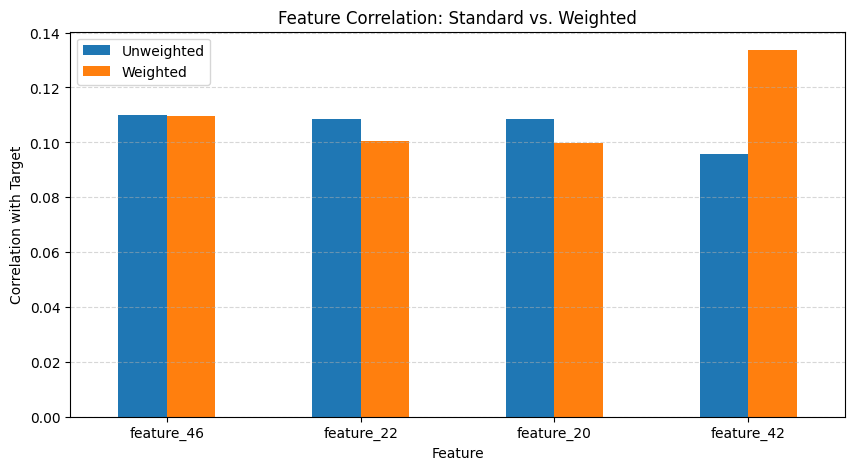

In [ ]:
plt.figure(figsize=(14, 5))

# Plot 1: Distribution of Weights
plt.subplot(1, 2, 1)
sns.histplot(sample_df['weight'], bins=50, kde=True, color='purple')
plt.title('Distribution of Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')

# Plot 2: Weight vs. Market Response (Volatility)
plt.subplot(1, 2, 2)
plt.scatter(sample_df['weight'], sample_df['responder_6'], alpha=0.3, s=10, c='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Weight vs. Responder_6 (Market Response)')
plt.xlabel('Weight')
plt.ylabel('Responder_6 Value')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

def get_weighted_corr(x, y, w):
    """Calculates correlation weighted by w."""
    valid = ~np.isnan(x) & ~np.isnan(y) & ~np.isnan(w)
    if not valid.any(): return np.nan

    stats = DescrStatsW(np.column_stack([x[valid], y[valid]]), weights=w[valid])
    return stats.corrcoef[0, 1]

features_to_check = ['feature_46', 'feature_22', 'feature_20', 'feature_42']

print(f"{'Feature':<15} | {'Unweighted':<12} | {'Weighted':<12} | {'Difference':<10}")
print("-" * 55)

results = []
for col in features_to_check:
    corr_unweighted = sample_df[col].corr(sample_df['responder_6'])
    corr_weighted = get_weighted_corr(sample_df[col], sample_df['responder_6'], sample_df['weight'])

    diff = corr_weighted - corr_unweighted
    results.append({'Feature': col, 'Unweighted': corr_unweighted, 'Weighted': corr_weighted})

    print(f"{col:<15} | {corr_unweighted:.4f}       | {corr_weighted:.4f}       | {diff:+.4f}")

results_df = pd.DataFrame(results)
if not results_df.empty:
    results_df.set_index('Feature')[['Unweighted', 'Weighted']].plot(kind='bar', figsize=(10, 5))
    plt.title('Feature Correlation: Standard vs. Weighted')
    plt.ylabel('Correlation with Target')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

This analysis assesses whether specific features perform better on high-value trades by comparing standard correlations against correlations weighted by the dataset's weight column. The output reveals that while most features like feature_22 and feature_20 see a slight performance drop on important trades, feature_42 shows a significant improvement. This is useful for our goal because it identifies feature_42 as a high-value signal which will be useful for our project's success metric of weighted accuracy.

In [ ]:
# --- Column inference utilities (safe, no assumptions) ---

def infer_first_present(df, candidates):
    """Return the first column name from candidates that exists in df."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

def infer_time_col(df):
    """Detect time column using common Jane Street-style naming conventions."""
    candidates = ["date_id", "time_id", "ts_id", "timestamp", "time"]
    return infer_first_present(df, candidates)

def infer_weight_col(df):
    """Detect sample weight column."""
    candidates = ["weight", "weights", "sample_weight"]
    return infer_first_present(df, candidates)

def infer_target_col(df, preferred="responder_6"):
    """Detect target column, preferring responder_6 if available."""
    if preferred in df.columns:
        return preferred
    responder_cols = [c for c in df.columns if c.startswith("responder_")]
    return responder_cols[0] if responder_cols else None

def infer_feature_cols(df):
    """Return sorted list of feature columns (feature_00 ... feature_78 style)."""
    feat_cols = [c for c in df.columns if c.startswith("feature_")]
    return sorted(feat_cols)

# Verify column inference on sample_df
print("Detected columns:")
print(f"  Time column: {infer_time_col(sample_df)}")
print(f"  Weight column: {infer_weight_col(sample_df)}")
print(f"  Target column: {infer_target_col(sample_df)}")
print(f"  Feature columns: {len(infer_feature_cols(sample_df))} found")

Detected columns:
  Time column: date_id
  Weight column: weight
  Target column: responder_6
  Feature columns: 79 found


Time-Aware Split + Leakage Prevention

**What this does:**
- Creates a chronological validation split (no shuffling)
- Adds leakage checks to ensure train data doesn't include future time relative to validation
- If there's no time column, falls back safely to "first chunk = train, last chunk = val" with a warning

In [ ]:
# --- Time-aware split + leakage checks ---

def make_time_split(df, time_col, val_frac=0.2):
    """
    Returns train_idx, val_idx such that train is strictly earlier than val.
    """
    if time_col is None:
        raise ValueError("No time column found; cannot do time-aware split.")
    order = np.argsort(df[time_col].to_numpy())
    n = len(order)
    cut = int(np.floor((1 - val_frac) * n))
    train_idx = order[:cut]
    val_idx = order[cut:]
    return train_idx, val_idx

def assert_time_separation(df, time_col, train_idx, val_idx):
    """Verify no time leakage: max(train time) <= min(val time)."""
    if time_col is None:
        return
    t_train_max = df.iloc[train_idx][time_col].max()
    t_val_min = df.iloc[val_idx][time_col].min()
    assert t_train_max <= t_val_min, (
        f"Time leakage risk: max(train {time_col})={t_train_max} "
        f"> min(val {time_col})={t_val_min}"
    )
    assert set(train_idx).isdisjoint(set(val_idx)), "Index overlap between train and val."

def safe_time_split_or_fallback(df, val_frac=0.2, verbose=True):
    """
    Attempt time-aware split; fall back to row-order split if no time column.
    Returns: (train_idx, val_idx, time_col_used_or_None)
    """
    time_col = infer_time_col(df)
    if time_col is None:
        if verbose:
            print("Warning: No time column found -> falling back to simple first/last split by row order.")
        # Fallback: preserves ordering, still avoids shuffling
        n = len(df)
        cut = int(np.floor((1 - val_frac) * n))
        train_idx = np.arange(0, cut)
        val_idx = np.arange(cut, n)
        return train_idx, val_idx, None
    train_idx, val_idx = make_time_split(df, time_col, val_frac=val_frac)
    assert_time_separation(df, time_col, train_idx, val_idx)
    if verbose:
        print(f"Time split using '{time_col}': train={len(train_idx)}, val={len(val_idx)}")
    return train_idx, val_idx, time_col

Weighted Accuracy + Evaluation Helpers

**What this does:**
- Implements sample-weighted accuracy correctly: sum(w_i * correct_i) / sum(w_i)
- Adds an optional threshold sweep to find the best validation threshold under weighted accuracy
- Provides helpers for converting probabilities to predictions

In [ ]:
# --- Weighted accuracy + evaluation helpers ---

def weighted_accuracy(y_true, y_pred, w=None):
    """
    Compute (optionally weighted) accuracy.
    If w is None, returns unweighted accuracy.
    """
    y_true = np.asarray(y_true).astype(int)
    y_pred = np.asarray(y_pred).astype(int)
    if w is None:
        return (y_true == y_pred).mean()
    w = np.asarray(w).astype(float)
    return np.sum(w * (y_true == y_pred)) / np.sum(w)

def get_weights_or_ones(df, weight_col, idx):
    """
    Extract weights for given indices, or return ones if no weight column.
    """
    if weight_col is None:
        return np.ones(len(idx), dtype=float)
    return df.iloc[idx][weight_col].to_numpy(dtype=float)

def proba_to_pred(proba, threshold=0.5):
    """Convert probability scores to binary predictions."""
    return (np.asarray(proba) >= threshold).astype(int)

def threshold_sweep(y_true, proba, w=None, thresholds=None):
    """
    Find the best threshold for weighted accuracy.
    Returns dict with 'threshold' and 'weighted_acc'.
    """
    if thresholds is None:
        thresholds = np.linspace(0.1, 0.9, 17)
    best = {"threshold": None, "weighted_acc": -np.inf}
    for th in thresholds:
        yp = proba_to_pred(proba, th)
        acc = weighted_accuracy(y_true, yp, w)
        if acc > best["weighted_acc"]:
            best = {"threshold": float(th), "weighted_acc": float(acc)}
    return best

Build Train/Val Matrices Safely (Binary Classification)

**What this does:**
- Creates binary labels: 1 if responder_6 > 0, else 0
- Builds train/val sets based on the time-aware split
- Uses weights if available, otherwise uses uniform weights (and logs this clearly)

In [ ]:
# --- Build train/val matrices safely (binary classification) ---

def build_xy(df, feature_cols, target_col, idx):
    """
    Build X (features) and y (binary direction label) for given indices.
    Also returns continuous target for reference.
    """
    X = df.iloc[idx][feature_cols]
    y_cont = df.iloc[idx][target_col].to_numpy(dtype=float)
    # Binary label: direction (1 if positive, 0 otherwise)
    y = (y_cont > 0).astype(int)
    return X, y, y_cont

Prepare Training Data with Time-Aware Split

This cell creates the train/val datasets using the time-aware split and the inferred columns.

In [ ]:
# --- Prepare train_df for modeling ---
# Use sample_df as our working dataframe (already loaded above)
train_df = sample_df.copy()

# Infer columns safely
target_col = infer_target_col(train_df, preferred="responder_6")
model_feature_cols = infer_feature_cols(train_df)
weight_col = infer_weight_col(train_df)

if target_col is None:
    raise ValueError("No target column found (expected responder_6 or responder_*).")

# Create time-aware split
train_idx, val_idx, time_col = safe_time_split_or_fallback(train_df, val_frac=0.2)

# Build X, y matrices
X_train, y_train, y_train_cont = build_xy(train_df, model_feature_cols, target_col, train_idx)
X_val, y_val, y_val_cont = build_xy(train_df, model_feature_cols, target_col, val_idx)

# Get weights
w_train = get_weights_or_ones(train_df, weight_col, train_idx)
w_val = get_weights_or_ones(train_df, weight_col, val_idx)

print("="*60)
print("DATA PREPARATION SUMMARY")
print("="*60)
print(f"Shapes: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"        X_val={X_val.shape}, y_val={y_val.shape}")
print(f"Using target: {target_col}")
print(f"Time column: {time_col if time_col else 'None (using row-order fallback)'}")
print(f"Weight column: {weight_col if weight_col else 'None (using uniform weights)'}")
print(f"Class balance (train): {y_train.mean():.4f} positive rate")
print(f"Class balance (val): {y_val.mean():.4f} positive rate")
print("="*60)

Time split using 'date_id': train=8000, val=2000
DATA PREPARATION SUMMARY
Shapes: X_train=(8000, 79), y_train=(8000,)
        X_val=(2000, 79), y_val=(2000,)
Using target: responder_6
Time column: date_id
Weight column: weight
Class balance (train): 0.4955 positive rate
Class balance (val): 0.5005 positive rate


Integrity & Assumption Checks

**What this does:**
- Ensures shape alignment, no NaNs, weights valid, and no leakage
- If it passes, you can confidently say: "I added time-aware validation + guardrails"

In [ ]:
# --- Integrity & assumption checks (should PASS) ---

def sanity_checks(train_df, train_idx, val_idx, X_train, y_train, w_train, X_val, y_val, w_val, time_col=None):
    """
    Run comprehensive sanity checks on the prepared data.
    Raises AssertionError if any check fails.
    """
    # Shape alignment
    assert len(train_idx) == len(X_train) == len(y_train) == len(w_train), \
        f"Train shape mismatch: idx={len(train_idx)}, X={len(X_train)}, y={len(y_train)}, w={len(w_train)}"
    assert len(val_idx) == len(X_val) == len(y_val) == len(w_val), \
        f"Val shape mismatch: idx={len(val_idx)}, X={len(X_val)}, y={len(y_val)}, w={len(w_val)}"

    # Weights are finite
    assert np.isfinite(w_train).all(), "Non-finite values in w_train"
    assert np.isfinite(w_val).all(), "Non-finite values in w_val"

    # No index overlap
    assert set(train_idx).isdisjoint(set(val_idx)), "Train/val index overlap detected!"

    # Check for NaNs in features (warn but don't fail - dataset may have legitimate NaNs)
    train_nan_count = np.isnan(X_train.to_numpy()).sum()
    val_nan_count = np.isnan(X_val.to_numpy()).sum()
    if train_nan_count > 0:
        print(f"Note: {train_nan_count} NaN values in X_train (may need imputation for some models)")
    if val_nan_count > 0:
        print(f"Note: {val_nan_count} NaN values in X_val (may need imputation for some models)")

    # Time separation check
    if time_col is not None:
        assert_time_separation(train_df, time_col, train_idx, val_idx)

    print("Sanity checks PASSED!")

# Run the checks
sanity_checks(train_df, train_idx, val_idx, X_train, y_train, w_train, X_val, y_val, w_val, time_col=time_col)

Note: 102671 NaN values in X_train (may need imputation for some models)
Note: 30757 NaN values in X_val (may need imputation for some models)
Sanity checks PASSED!


---
## How to Use These Contributions with Your Models

The variables created above are ready for model training:

```python
# Training (use X_train, y_train)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_val)
# OR for probability-based models:
proba = model.predict_proba(X_val)[:, 1]
y_pred = proba_to_pred(proba, threshold=0.5)

# Evaluation with weighted accuracy
val_weighted_acc = weighted_accuracy(y_val, y_pred, w_val)
print(f"Weighted Accuracy: {val_weighted_acc:.4f}")

# Optional: Find best threshold
best = threshold_sweep(y_val, proba, w_val)
print(f"Best threshold: {best['threshold']:.2f}, Weighted Acc: {best['weighted_acc']:.4f}")
```

**Note:** All existing model training code works unchanged - just use `X_train`, `y_train`, `X_val`, `y_val` as before.
